# Machine Vision
## Assignment 1 – Imaging

## Introduction

In this assignment, you will read and display images in Python, use a depth map to simulate shallow depth of field (Bokeh effect), and simulate vignetting to create brightness fall-off near image edges. Please study __[`Lecture 2`](https://moodle.oulu.fi/mod/page/view.php?id=1705510)__ and the sample code in __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__ before starting. The figure below shows the expected final outcome.

<img src="fig1.jpg">


## Task 1 – Read and display images (0.5 points)

In this task, you will practice basic image reading and visualization. You will load a color image and a depth map, then display them side by side. The depth map was generated using __[`DepthAnything-V2`](https://github.com/DepthAnything/Depth-Anything-V2)__, a state-of-the-art monocular depth estimation method that predicts relative depth from a single image. The depth map has been manually adjusted to approximate metric depth and is stored as a 16-bit image with depth values in millimeters.

### Instructions
- **Read** `image.jpg` and `depth.png` using the OpenCV library. Use the flag `cv2.IMREAD_UNCHANGED` to properly read the 16-bit depth map.
- **Convert** the color image from BGR to RGB as this is the order of color channels expected by Matplotlib.
- **Display** both images side by side using Matplotlib.


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

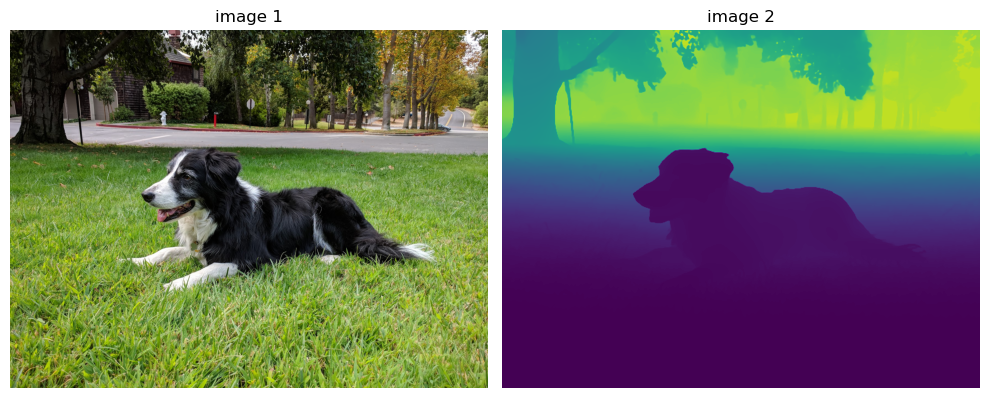

In [2]:
# ---------- YOUR CODE STARTS HERE -----------

img1 = cv2.imread('image.jpg', cv2.IMREAD_UNCHANGED)
img2 = cv2.imread('depth.png', cv2.IMREAD_UNCHANGED)

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img1)  
plt.title('image 1')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('image 2')
plt.axis('off')

plt.tight_layout()
plt.show()
# ----------- YOUR CODE ENDS HERE ------------

## Task 2 – Synthetic Bokeh (0.5 points)

In this task, you will simulate a shallow depth-of-field effect, commonly referred to as the **Bokeh effect**. This effect is achieved by blurring parts of the image that are not in focus, mimicking the behavior of a lens with a wide aperture (small F-number). Smartphones typically have small sensors and large depth of field, resulting in images where both foreground and background are sharp. By artificially simulating defocus blur, we can create the Bokeh effect, selectively emphasizing the object in focus (e.g., the dog in the provided image).

### Background
The **thin-lens equation** is the foundation of defocus blur simulation:

$$\frac{1}{f} = \frac{1}{z_o} + \frac{1}{z_i}$$

- $f$ is the focal length of the lens (in mm).
- $z_o$ is the distance to the object being photographed (in mm).
- $z_i$ is the distance to the image plane (in mm).

Points outside the focus plane appear as small blurred circles, referred to as the circle of confusion (CoC). The size of the CoC depends on the distance of the point from the focus plane and is given by:
$$c = D \cdot \frac{|z_f - z_i|}{z_i}$$
where:
- $D$ is the aperture diameter (in mm), calculated as $D = \frac{f}{N}$, where $N$ is the F-number.
- $z_f$ is the image distance for the focus plane (in mm).
- $z_i$ is the image distance for a given depth (in mm).

The size of the CoC, converted to pixels using a sensor-specific scaling factor, determines the extent of blur applied to each pixel. The scaling factor, `pixels_per_mm`, is calculated based on the physical size of the sensor (e.g., 36 mm) and the resolution of the image, linking real-world measurements to pixel dimensions.

The function `defocus_blur` below (adapted from __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__) uses this model to simulate defocus blur by applying a Gaussian blur proportional to the CoC size. While Gaussian blur is simple and efficient, a more physically accurate approach would involve using a disk-shaped kernel to mimic the shape of an aperture.

In [3]:
def defocus_blur(img, depth, f, D, fdist, pixels_per_mm):
    """
    Apply a synthetic defocus blur based on the thin-lens model.

    Parameters
    ----------
    img : Color image (H x W x 3)
    depth : Depth map in mm (H x W)
    f : Focal length in mm
    D : Aperture diameter in mm
    fdist : Focus distance (mm)
    pixels_per_mm : Conversion factor from mm to pixels

    Returns
    -------
    blurred : The blurred image
    """

    depth = depth.astype(np.float32)
    zf = 1.0 / (1.0/f - 1.0/fdist)  # image distance for the focus plane
    zi = 1.0 / (1.0/f - 1.0/depth)  # image distance for each pixel

    dz = np.abs(zf - zi)
    c = D * (dz / zi)          # circle of confusion in mm
    c *= pixels_per_mm         # convert mm -> pixels
    c = np.clip(c, 0.0, 150.0) # limit the maximum size for safety

    ci = np.linspace(c.min(), c.max(), 20)
    dc = np.digitize(c, ci)
    blurred = np.zeros_like(img)

    for i in range(20):
        sigma = ci[i]/2 + 0.01
        gblur = cv2.GaussianBlur(img, (0,0), sigma)
        mask = (dc == i+1).astype(np.uint8)
        blurred += cv2.bitwise_and(gblur, gblur, mask=mask)

    return blurred

### Instructions
- **Use** the provided `defocus_blur` function to apply synthetic Bokeh to the image.
- **Assume** the dog is approximately 10 meters away (10 000 mm).
- **Set** the focal length $f = 200$ mm and the F-number $N = 2.0$.
- **Compute** `pixels_per_mm` by dividing the image width by 36 (mm). 
- **Display** the resulting image with Bokeh effect.


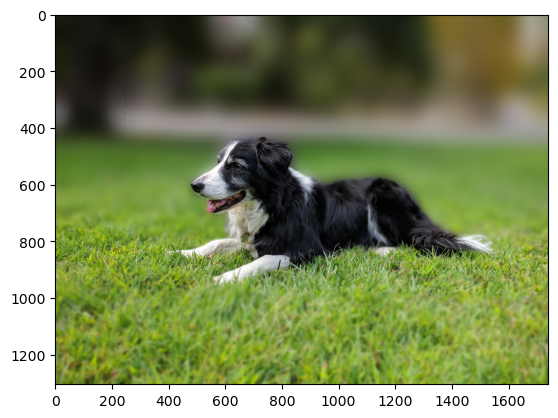

In [4]:
# ---------- YOUR CODE STARTS HERE -----------
D = 200 / 2.0
pixels_per_mm = img1.shape[1] / 36

bokeh_img = defocus_blur(img1, img2, 200, D, 10000, pixels_per_mm)

plt.imshow(bokeh_img)  
plt.show()
# ----------- YOUR CODE ENDS HERE ------------

## Task 3 – Vignetting (1.0 point)

Vignetting refers to the reduction of brightness near the edges of an image, which is a common effect in photography. This phenomenon is often modeled by the cosine fourth law (refer to __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__ for an example). However, in this task, you will create an artistic vignetting effect using an exponential falloff model:

$$ I'(x, y) = I(x, y) \times \exp\left(-\frac{d^2}{\sigma^2}\right) $$

where:
- $I'(x, y)$: the modified pixel intensity.
- $I(x, y)$: the original pixel intensity.
- $d$: the distance from a pixel to the image center.
- $\sigma$: a parameter controlling the vignetting strength.

### Instructions
- **Set** $\sigma = \mathrm{width} / 2$, where $\mathrm{width}$ is the width of the input image.
- **Compute** the distance $d$ from each pixel to the image center (see __[`Imaging.ipynb`](https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb)__).
- **Apply** the exponential brightness falloff to the image from the previous task.
- **Visualize** the final result with Bokeh and vignetting effects.

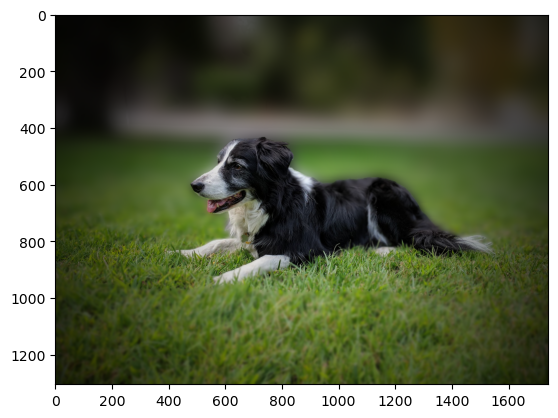

In [5]:
# ---------- YOUR CODE STARTS HERE -----------
xi, yi = np.meshgrid(range(bokeh_img.shape[1]),range(bokeh_img.shape[0]))
xi = xi.astype(np.float32) - bokeh_img.shape[1]/2
yi = yi.astype(np.float32) - bokeh_img.shape[0]/2
di = np.sqrt(xi**2 + yi**2)

sigma = bokeh_img.shape[1] / 2
fall_off = np.exp(- di**2 / sigma**2)
fall_off = np.stack([fall_off, fall_off, fall_off], axis=2)

vig_img = (bokeh_img * fall_off).astype(np.uint8)

plt.imshow(vig_img)
plt.show()
# ----------- YOUR CODE ENDS HERE ------------

# References

`List any references here (optional).`

I got help from the repo https://github.com/jtheikkila/mvis/blob/master/jupyter/Imaging.ipynb you provided.